# Importing
### Import library

In [1]:
"""Import library""" 
import numpy as np
import pandas as pd 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Activation, MaxPool2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
from tensorflow.keras.applications import ResNet50V2 as ResNet
from tensorflow.keras.callbacks import EarlyStopping,  ReduceLROnPlateau
from tensorflow.keras.models import load_model

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

import cv2
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})
palette = sns.color_palette("bright", 28)

import random
import os

import imutils
from imutils.contours import sort_contours

### Import dataset

In [2]:
def extractImages(datadir):
    # Get the data
    imagesData = []
    imagesLabel = []
    for folder in os.listdir(datadir):
        path = os.path.join(datadir, folder)
        for images in os.listdir(path):
            img = cv2.imread(os.path.join(path, images), cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (32, 32))
            imagesData.append(img)
            imagesLabel.append(folder)
            
    # Shuffle data
    combined = list(zip(imagesData, imagesLabel))
    random.shuffle(combined)
    imagesData, imagesLabel = zip(*combined)
    
    return (imagesData, imagesLabel)

In [3]:
# Import train data
imagesData = []
imagesLabel = []
train_data_dir = 'C:/Users/aryap/OneDrive/Desktop/PYTHON LANGUAGE/Maths_Handwritten_Project/Dataset'

imagesData, imagesLabel = extractImages(train_data_dir)

print("number of image: ",len(imagesData))        
print("shape of image: ",imagesData[1].shape)
print("labels:    ",list(set(imagesLabel)))

number of image:  69916
shape of image:  (32, 32)
labels:     ['0', '-', 'neq', '{', 'cos', 'sqrt', 'Delta', 'exists', 'times', 'theta', '8', 'int', 'lim', 'sin', 'phi', '3', 'gt', '=', '6', ')', 'sigma', '}', '!', ',', ']', '7', '5', '+', 'infty', '(', '[', 'i', 'gamma', '2', 'beta', 'sum', 'alpha', 'div', 'forall', '4', 'log', '9', 'pi', 'geq', 'forward_slash', 'mu', 'in', 'tan', 'leq', '1']


In [4]:
imagesTrainData, imagesTestData, imagesTrainLabel, imagesTestLabel = train_test_split(imagesData, imagesLabel, shuffle=True, test_size=0.2, random_state=42, stratify = imagesLabel)

---
# Data Exploring
### Show Dataset Image

In [5]:
# Show Image
def showImage (images,label,part):
    figure = plt.figure(figsize=((len(part)/10 + 1)*10, (len(part)/10 + 1)*2))
    j = 0
    for i in part:
        lbl = label[i]
        img = images[i]
        img = cv2.resize(img, (256, 256))
        figure.add_subplot(int(len(part)/10)+1, 10, j+1)
        plt.imshow(img,cmap='gray')
        plt.axis('off')
        plt.title(lbl)
        j += 1

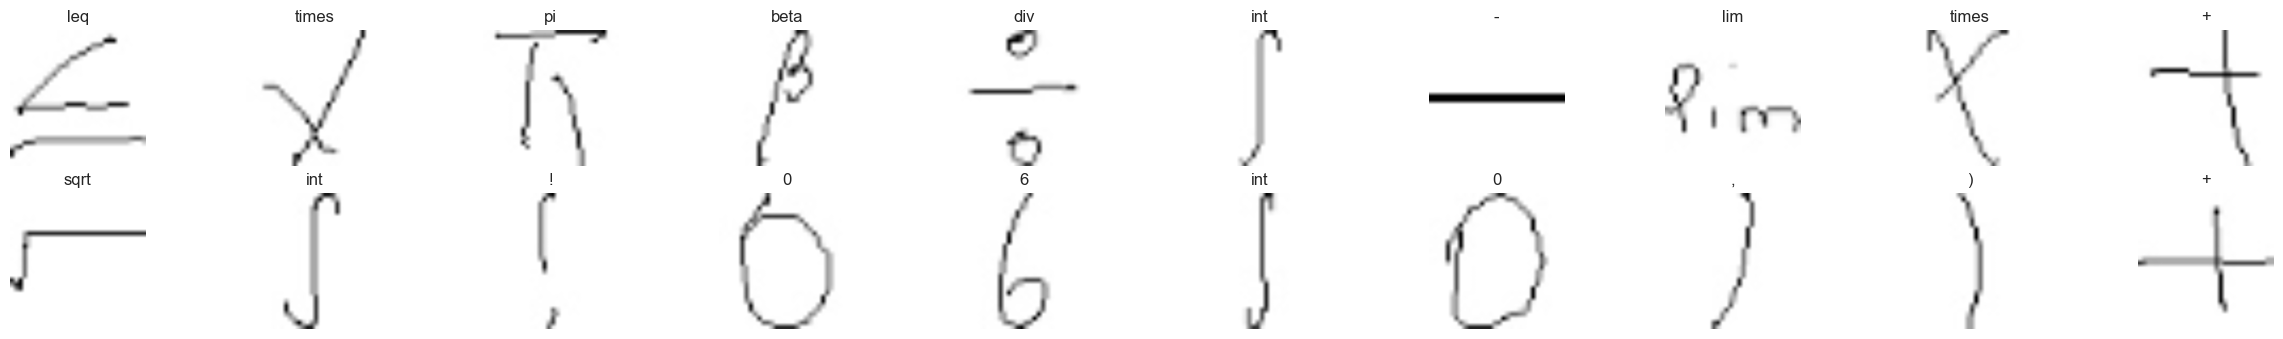

In [6]:
showImage(imagesTrainData,imagesTrainLabel, range(20))

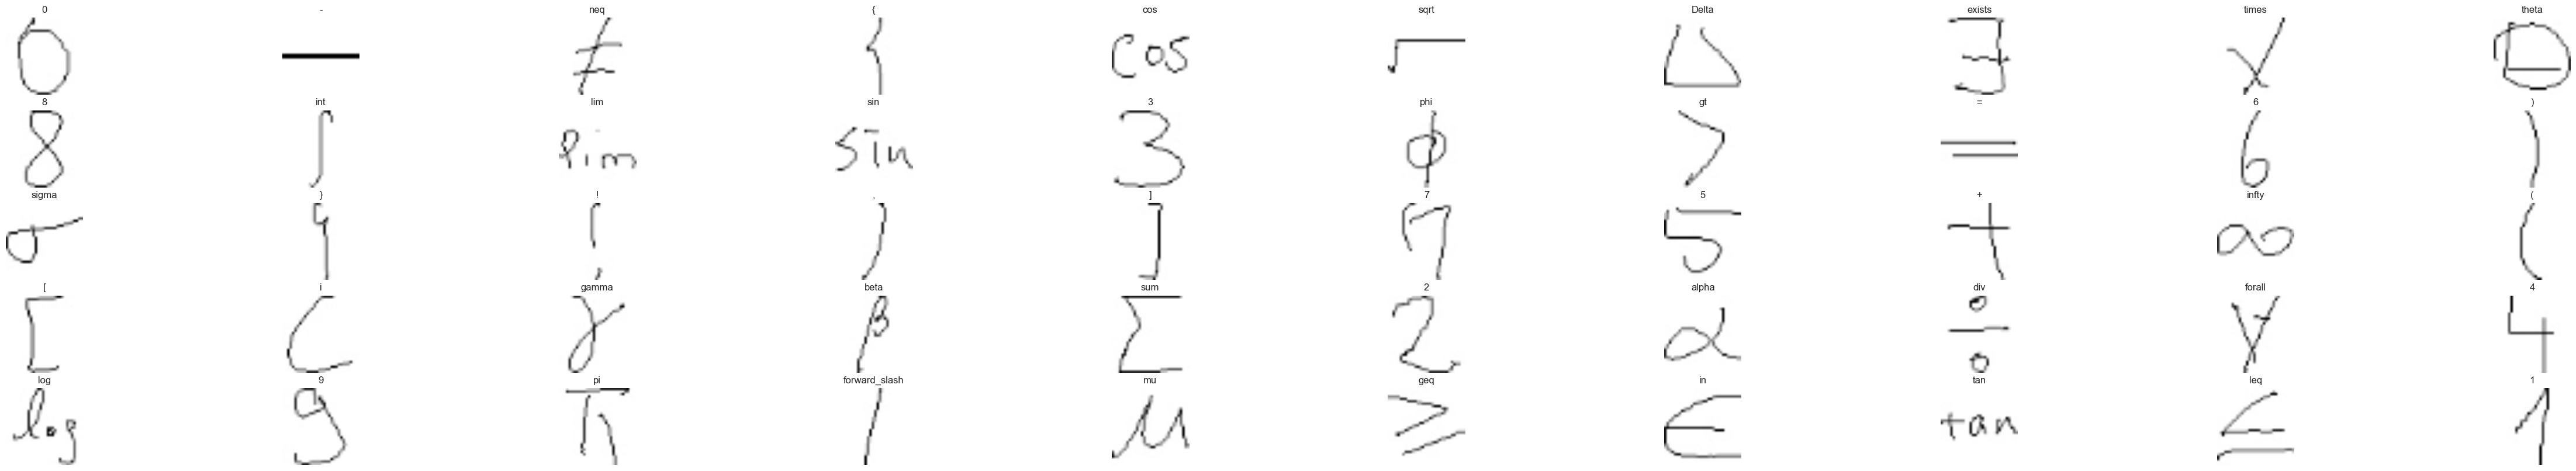

In [7]:
unique_idx = [imagesTrainLabel.index(i) for i in list(set(imagesTrainLabel))]
showImage(imagesTrainData,imagesTrainLabel, unique_idx )

### Visualizing the Distribution of Images

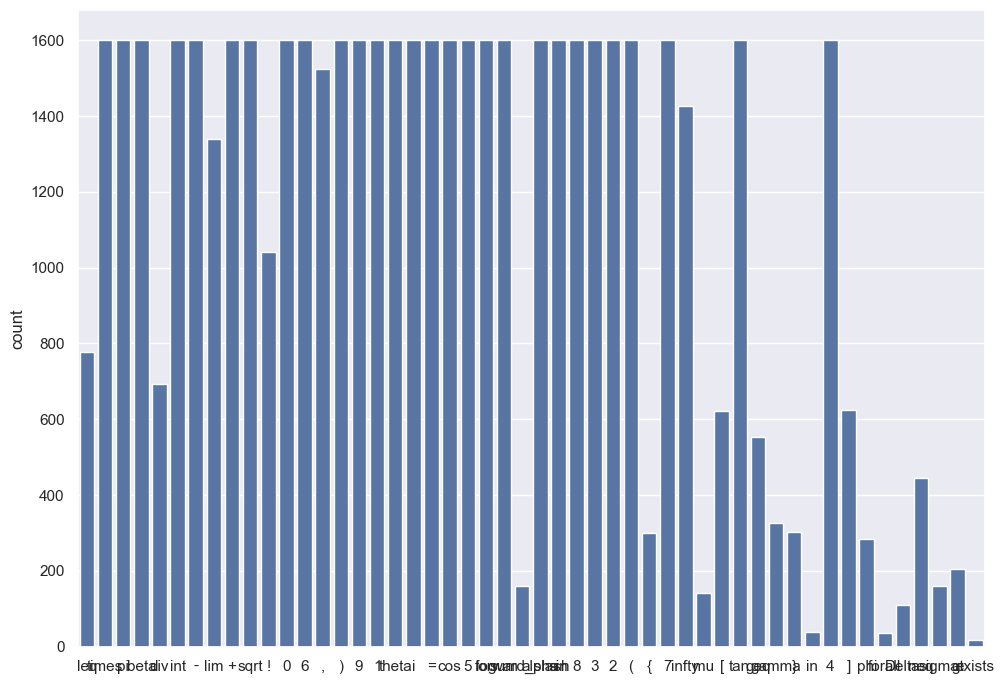

In [8]:
sns.countplot(x= list(imagesTrainLabel));

we can see data nearly balanced

---
# Preprocessing


### Encoding

In [9]:
label_encoder = LabelEncoder()
Y_train = label_encoder.fit_transform(imagesTrainLabel)
Y_test = label_encoder.transform(imagesTestLabel)

In [10]:
Y_train = to_categorical(Y_train)
Y_test = to_categorical(Y_test)

### Scaling

In [11]:
X_train = np.array(imagesTrainData)
X_test = np.array(imagesTestData)
Y_train = np.array(Y_train)
Y_test = np.array(Y_test)

X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)
X_train = X_train/255.
X_test = X_test/255.

print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(55932, 32, 32, 1)
(13984, 32, 32, 1)
(55932, 50)
(13984, 50)


In [12]:
X_train[0].shape

(32, 32, 1)

---
# CNN Model

In [13]:
def digit_recognition(input_shape=(32, 32, 1)):
   
    
    model = Sequential()   

    model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape =input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(50, activation='softmax'))

    model.compile(optimizer=Adam(learning_rate=0.0001,), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

In [14]:
model = digit_recognition()
model.summary()

c:\Users\aryap\anaconda3\envs\ML\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 128)    │        36,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     8,389,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 50)             │        51,250 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,478,834 (32.34 MB)

 Trainable params: 8,478,514 (32.34 MB)

 Non-trainable params: 320 (1.25 KB)

In [15]:
def step_decay(epoch):
    initial_learning_rate = 0.001
    dropEvery = 10
    factor = 0.5
    lr = initial_learning_rate*(factor**np.floor((1 + epoch)/dropEvery))
    return float(lr)

checkpoint = ModelCheckpoint('HandwrittenMathEquationModel.keras', 
                             monitor='val_accuracy', 
                             save_best_only=True, 
                             verbose=1, 
                             mode='min')

earlyStopping = EarlyStopping(monitor='val_accuracy', 
                              mode='auto', 
                              verbose=1, 
                              patience=10, 
                              restore_best_weights=True)

reduceLr = ReduceLROnPlateau(monitor='val_accuracy', 
                              factor=0.2, 
                              patience=6, 
                              verbose=1, 
                              min_delta=0.0001)

callbacks = [checkpoint,earlyStopping,reduceLr, LearningRateScheduler(step_decay)]

In [16]:
# Image Augmentation 
aug = ImageDataGenerator(zoom_range=0.1,
                         rotation_range=5,
                         width_shift_range=0.05,
                         height_shift_range=0.05)

In [17]:
hist = model.fit(aug.flow(X_train, Y_train, batch_size=64), batch_size=64, epochs=90, validation_data=(X_test, Y_test), callbacks=callbacks)

Epoch 1/90


c:\Users\aryap\anaconda3\envs\ML\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


874/874 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.5746 - loss: 2.7833
Epoch 1: val_accuracy improved from inf to 0.79798, saving model to HandwrittenMathEquationModel.keras
874/874 ━━━━━━━━━━━━━━━━━━━━ 121s 135ms/step - accuracy: 0.5748 - loss: 2.7818 - val_accuracy: 0.7980 - val_loss: 0.8187 - learning_rate: 0.0010
Epoch 2/90
874/874 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.8315 - loss: 0.7175
Epoch 2: val_accuracy improved from 0.79798 to 0.59103, saving model to HandwrittenMathEquationModel.keras
874/874 ━━━━━━━━━━━━━━━━━━━━ 115s 132ms/step - accuracy: 0.8315 - loss: 0.7174 - val_accuracy: 0.5910 - val_loss: 3.8614 - learning_rate: 0.0010
Epoch 3/90
874/874 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.8679 - loss: 0.5564
Epoch 3: val_accuracy did not improve from 0.59103
874/874 ━━━━━━━━━━━━━━━━━━━━ 115s 131ms/step - accuracy: 0.8679 - loss: 0.5564 - val_accuracy: 0.6733 - val_loss: 1.7485 - learning_rate: 0.0010
Epoch 4/90
874/874 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/st

In [18]:
model.save(filepath='equation_model.keras')

In [19]:
model.save('EquationModel.keras')

In [20]:
model.save('EquationModel.h5')

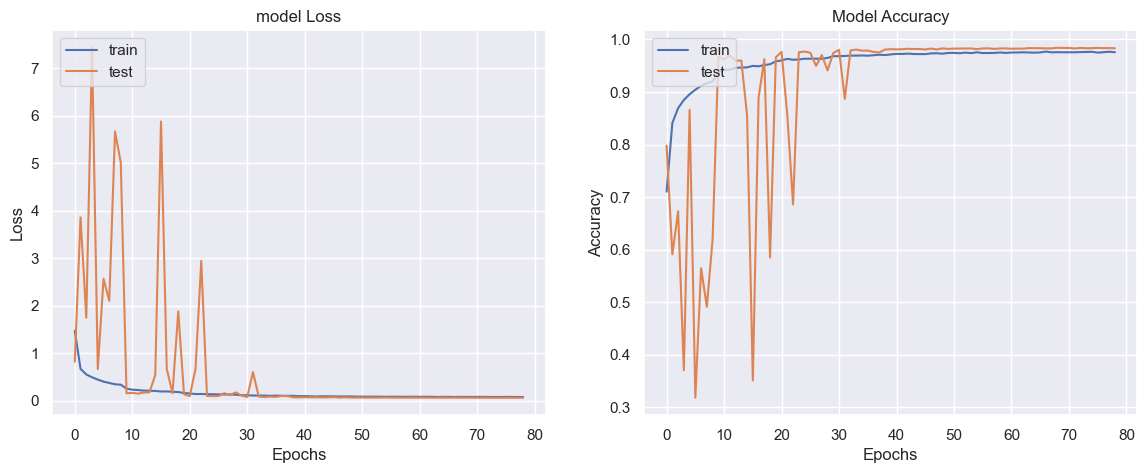

In [21]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,2)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(1,2,1)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Model Evaluation¶

In [22]:
train_loss, train_accu = model.evaluate(X_train, Y_train)
test_loss, test_accu = model.evaluate(X_test, Y_test)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

1748/1748 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - accuracy: 0.9874 - loss: 0.0429
437/437 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9836 - loss: 0.0591
final train accuracy = 98.75 , validation accuracy = 98.41


> **Excellent accuracy is achieved on training set and  validation set 💪**

### Confusion Matrix and Classification on training set

In [23]:
def confusion_mat(X, y):
    y_pred = model.predict(X)
    y_pred = np.argmax(y_pred, axis=1)
    y_target = np.argmax(y, axis=1)
    target_names = label_encoder.classes_
    
    print('Classification Report')
    target_names = label_encoder.classes_
    print(classification_report(y_target, y_pred, target_names=target_names))
    
    print('Confusion Matrix')
    cm_train = confusion_matrix(y_target , y_pred)
    print(cm_train)
    
    plt.figure(figsize=(5,5))
    plt.imshow(cm_train, interpolation='nearest')
    plt.colorbar()
    tick_mark = np.arange(len(target_names))
    _ = plt.xticks(tick_mark, target_names, rotation=90)
    _ = plt.yticks(tick_mark, target_names)

1748/1748 ━━━━━━━━━━━━━━━━━━━━ 17s 10ms/step
Classification Report
               precision    recall  f1-score   support

            !       1.00      1.00      1.00      1040
            (       0.95      0.99      0.97      1600
            )       0.91      0.97      0.94      1600
            +       1.00      1.00      1.00      1600
            ,       0.83      0.79      0.81      1525
            -       0.99      1.00      0.99      1600
            0       1.00      1.00      1.00      1600
            1       0.92      0.91      0.92      1600
            2       1.00      1.00      1.00      1600
            3       1.00      1.00      1.00      1600
            4       1.00      1.00      1.00      1600
            5       1.00      1.00      1.00      1600
            6       1.00      1.00      1.00      1600
            7       1.00      1.00      1.00      1600
            8       1.00      1.00      1.00      1600
            9       1.00      1.00      1.00      16

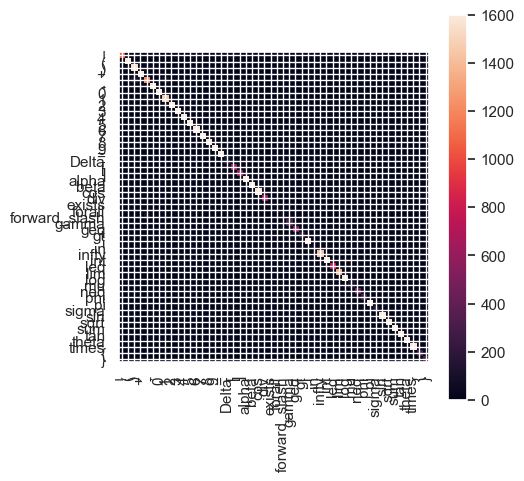

In [24]:
# Train Set
confusion_mat(X_train,Y_train)

437/437 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step
Classification Report
               precision    recall  f1-score   support

            !       1.00      1.00      1.00       260
            (       0.94      0.98      0.96       400
            )       0.92      0.98      0.95       400
            +       1.00      0.99      1.00       400
            ,       0.85      0.78      0.81       381
            -       0.99      0.99      0.99       400
            0       1.00      0.99      0.99       400
            1       0.88      0.91      0.90       400
            2       1.00      0.98      0.99       400
            3       1.00      0.99      1.00       400
            4       1.00      0.98      0.99       400
            5       1.00      1.00      1.00       400
            6       1.00      1.00      1.00       400
            7       0.99      1.00      0.99       400
            8       1.00      1.00      1.00       400
            9       0.99      0.99      0.99       400


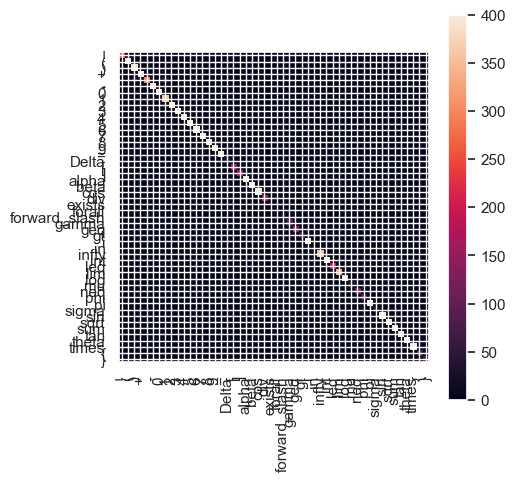

In [25]:
# Test Set
confusion_mat(X_test,Y_test)

---
# Test the model


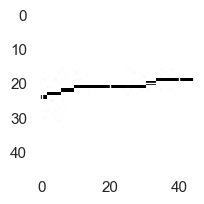

In [26]:
# Get test image
image = cv2.imread('Img_Folder/-/-_66.jpg',cv2.IMREAD_GRAYSCALE)
plt.figure(figsize=(2, 2))
plt.imshow(image,cmap='gray')
plt.show()

In [6]:
def image_preprocessing(image):
    image = cv2.resize(image, (32, 32))
    arrim = np.array(image)
    arrim = np.expand_dims(arrim, axis=-1)
    arrim = arrim/255.
    arrim = np.array([np.array(arrim)])
    return arrim

In [28]:
# Make a prediction
prediction = model.predict(image_preprocessing(image))
prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


array([[3.47852845e-12, 5.43361779e-11, 9.22514493e-14, 3.95354988e-07,
        6.24830136e-04, 9.99095321e-01, 4.09516240e-11, 8.90145913e-08,
        7.58942679e-06, 7.46085702e-13, 1.13202918e-06, 5.86686299e-12,
        6.75519406e-15, 1.11652064e-07, 2.33932903e-15, 1.58309466e-12,
        2.41521673e-04, 1.13500901e-20, 6.98402856e-14, 1.54988606e-16,
        1.46559793e-13, 5.89661647e-15, 1.40804303e-14, 1.41646282e-07,
        5.02919703e-22, 5.89527487e-20, 5.08960456e-15, 1.59980476e-16,
        4.85333108e-15, 4.11546389e-16, 1.60086083e-12, 1.17672824e-15,
        2.37520864e-10, 8.01893545e-14, 5.36543813e-12, 8.59108355e-16,
        1.72335150e-18, 1.64073348e-14, 2.49508615e-14, 3.47543715e-20,
        7.35110161e-13, 2.08653598e-11, 3.99710147e-15, 2.89574455e-05,
        4.24762188e-14, 6.52068621e-16, 2.56002196e-13, 8.26369463e-13,
        4.45844347e-15, 7.45074850e-16]], dtype=float32)

In [29]:
label_encoder.classes_[np.argmax(prediction)]

'-'

In [30]:
label_encoder.classes_

array(['!', '(', ')', '+', ',', '-', '0', '1', '2', '3', '4', '5', '6',
       '7', '8', '9', '=', 'Delta', '[', ']', 'alpha', 'beta', 'cos',
       'div', 'exists', 'forall', 'forward_slash', 'gamma', 'geq', 'gt',
       'i', 'in', 'infty', 'int', 'leq', 'lim', 'log', 'mu', 'neq', 'phi',
       'pi', 'sigma', 'sin', 'sqrt', 'sum', 'tan', 'theta', 'times', '{',
       '}'], dtype='<U13')

In [ ]:
import cv2
import imutils
import numpy as np
import matplotlib.pyplot as plt

def process_image(image_path, model):
    # Constants
    MIN_WIDTH = 20
    MIN_HEIGHT = 30

    chars = []
    img = cv2.imread(image_path)
    img = cv2.resize(img, (800, 800))
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    edged = cv2.Canny(img_gray, 30, 150)
    contours = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = imutils.grab_contours(contours)
    contours = imutils.sort_contours(contours, method="left-to-right")[0]
    
    labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'add', 'div', 'mul', 'sub']

    for c in contours:
        (x, y, w, h) = cv2.boundingRect(c)
        if w >= MIN_WIDTH and h >= MIN_HEIGHT:
            roi = img_gray[y:y+h, x:x+w]
            thresh = cv2.threshold(roi, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
            (th, tw) = thresh.shape

            if tw > th:
                thresh = imutils.resize(thresh, width=32)
            if th > tw:
                thresh = imutils.resize(thresh, height=32)

            (th, tw) = thresh.shape
            dx = int(max(0, 32 - tw) / 2.0)
            dy = int(max(0, 32 - th) / 2.0)
            padded = cv2.copyMakeBorder(thresh, top=dy, bottom=dy, left=dx, right=dx, borderType=cv2.BORDER_CONSTANT, value=(0, 0, 0))
            padded = cv2.resize(padded, (32, 32))
            
            # Image preprocessing as requested
            arrim = np.array(padded)
            arrim = np.expand_dims(arrim, axis=-1)
            arrim = arrim / 255.
            arrim = np.array([np.array(arrim)])
            
            pred = model.predict(arrim)
            pred = np.argmax(pred, axis=1)

            label = labels[pred[0]]
            chars.append(label)

            cv2.rectangle(img, (x, y), (x+w, y+h), (0, 0, 255), 2)
            cv2.putText(img, label, (x-5, y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255))

    # Display the image
    figure = plt.figure(figsize=(10, 10))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    
    expression = ''.join(['+' if i == 'add' else '-' if i == 'sub' else '*' if i == 'mul' else '/' if i == 'div' else i for i in chars])
    result = eval(expression)
    
    print('Value of the expression {}: {}'.format(expression, result))

# Example usage:
# model = your_model  # Make sure to provide the model you're


In [1]:
import tensorflow as tf
model = tf.keras.models.load_model(r'D:\Math NotePad\backend\EquationModel.keras')

In [2]:
import cv2
import numpy as np

def image_preprocessing(image):
    image = cv2.resize(image, (32, 32))
    arrim = np.array(image)
    cv2.imshow('image', arrim)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    arrim = np.expand_dims(arrim, axis=-1)
    arrim = arrim/255.
    arrim = np.array([np.array(arrim)])
    return arrim

image = cv2.imread('image.jpg', cv2.IMREAD_GRAYSCALE)
print(image.shape)
arrim = image_preprocessing(image)

cv2.imshow('image', arrim)
cv2.waitKey(0)
cv2.destroyAllWindows()

print(arrim.shape)
prediction = model.predict(arrim)
prediction

(45, 45)


error: OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\highgui\src\window_w32.cpp:124: error: (-215:Assertion failed) bmi && width >= 0 && height >= 0 && (bpp == 8 || bpp == 24 || bpp == 32) in function 'FillBitmapInfo'


: 

In [5]:
Digits = ['!', '(', ')', '+', ',', '-', '0', '1', '2', '3', '4', '5', '6','7', '8', '9', '=', 
                      'Delta', '[', ']', 'alpha', 'beta', 'cos','div', 'exists', 'forall',        
                      'forward_slash', 'gamma', 'geq', 'gt', 'i', 'in', 'infty', 'int', 
                      'leq', 'lim', 'log', 'mu', 'neq', 'phi', 'pi', 'sigma', 'sin', 'sqrt', 
                      'sum', 'tan', 'theta', 'times', '{', '}']
print(Digits[np.argmax(prediction)])

7
